# Crear unidades espaciales para agregar datos de puntos

En este notebook podemos ver como crear unidades espaciales ad-hoc para agregar puntos cuando no contemos con unidades existentes (radios censales, departamentos, barrios, etc). Veremos grillas uniformes que dividen el espacio de analisis en celdas de determinado tamaño y [poligonos voronoi](https://es.wikipedia.org/wiki/Pol%C3%ADgonos_de_Thiessen) que dividen el espacio de acuerdo a la distribución de los datos existentes (en forma de puntos) 

## Grillas

In [1]:
import geopandas as gpd
from shapely.geometry import Point,Polygon,LineString
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

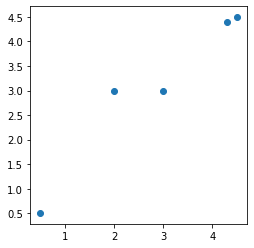

In [2]:
#creamos los puntos
puntos = gpd.GeoDataFrame(geometry = [Point(4.5,4.5),Point(4.3,4.4),Point(0.5,0.5),Point(2,3),
                                     Point(3,3)],crs = {'init':'epsg:3857'})
puntos.plot()

In [3]:
#creamos un espacio de analisis apartir del rango del espacio donde se encuentran nuestros puntos
xmin,ymin,xmax,ymax = puntos.total_bounds

In [4]:
puntos.total_bounds

array([0.5, 0.5, 4.5, 4.5])

In [5]:
#establecemos un ancho y un alto de nuestras celdas y en base a eso construimos 
#la cantidad de filas y columnas que vamos a tener en nuestro espacio de analisis

ancho_celda = 1
alto_celda = 1
filas = int(np.ceil((ymax-ymin) /  alto_celda))
columnas = int(np.ceil((xmax-xmin) / ancho_celda))
filas

4

In [6]:
#iniciamos las coordenadas de los vertices (puntos) de la primer celda 
#(que va a esatr ubicada arriba a la izquierda del espacio de analisis)
XleftOrigin = xmin
XrightOrigin = xmin + ancho_celda
YtopOrigin = ymax
YbottomOrigin = ymax - alto_celda
print('Xleftorigin',XleftOrigin)
print('Xrightorigin',XrightOrigin)
print('YtopOrigin',YtopOrigin)
print('YbottomOrigin',YbottomOrigin)

Xleftorigin 0.5
Xrightorigin 1.5
YtopOrigin 4.5
YbottomOrigin 3.5


In [7]:
#creamos una lista vacia donde vamos a ir agregando los poligonos creados
polygons = []
#primero recorremos todas las columnas
for i in range(columnas):
    Ytop = YtopOrigin
    Ybottom =YbottomOrigin
    #dentro de cada columna recorremos cada fila
    for j in range(filas):
        #greamos un poligono a partir de las coordenadas de puntos de los vertices
        polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
        #actualizamos las coordenadas de puntos
        Ytop = Ytop - alto_celda
        Ybottom = Ybottom - alto_celda
    XleftOrigin = XleftOrigin + ancho_celda
    XrightOrigin = XrightOrigin + ancho_celda

#creamos un geodataframe con los poligonos
grilla = gpd.GeoDataFrame({'geometry':polygons},crs = {'init':'epsg:3857'})
#guaardamos la grilla
grilla.to_file("../carto/grid.shp")

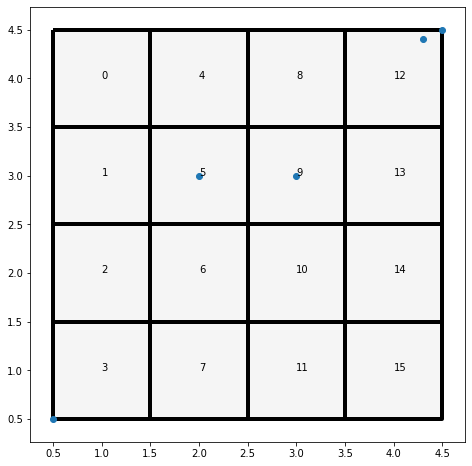

In [8]:
f,ax=plt.subplots(1,figsize=(8,8))
grilla.plot(ax=ax,facecolor='whitesmoke',edgecolor = 'black',linewidth = 4)
puntos.plot(ax=ax)
for i,geom in enumerate(grilla.geometry):
    ax.annotate(grilla.index[i],xy=(geom.centroid.x,geom.centroid.y))

In [10]:
#hacemos un join espacial para chequear que coincidan
tabla = gpd.sjoin(puntos,grilla)
tabla

,geometry,index_right
0,POINT (4.50000 4.50000),12
1,POINT (4.30000 4.40000),12
2,POINT (0.50000 0.50000),3
3,POINT (2.00000 3.00000),5
4,POINT (3.00000 3.00000),9


In [12]:
tabla = tabla.groupby('index_right').count().reset_index()


,index_right,geometry
0,3,1
1,5,1
2,9,1
3,12,2


In [15]:
tabla.columns = ['index','n']

In [16]:
tabla


,index,n
0,3,1
1,5,1
2,9,1
3,12,2


In [14]:
grilla = grilla.reset_index()
grilla

,index,geometry
0,0,"POLYGON ((0.50000 4.50000, 1.50000 4.50000, 1...."
1,1,"POLYGON ((0.50000 3.50000, 1.50000 3.50000, 1...."
2,2,"POLYGON ((0.50000 2.50000, 1.50000 2.50000, 1...."
3,3,"POLYGON ((0.50000 1.50000, 1.50000 1.50000, 1...."
4,4,"POLYGON ((1.50000 4.50000, 2.50000 4.50000, 2...."
5,5,"POLYGON ((1.50000 3.50000, 2.50000 3.50000, 2...."
6,6,"POLYGON ((1.50000 2.50000, 2.50000 2.50000, 2...."
7,7,"POLYGON ((1.50000 1.50000, 2.50000 1.50000, 2...."
8,8,"POLYGON ((2.50000 4.50000, 3.50000 4.50000, 3...."
9,9,"POLYGON ((2.50000 3.50000, 3.50000 3.50000, 3...."


In [21]:
ploteo = grilla.merge(tabla,on='index',how='left')
ploteo

,index,geometry,n
0,0,"POLYGON ((0.50000 4.50000, 1.50000 4.50000, 1....",NaN
1,1,"POLYGON ((0.50000 3.50000, 1.50000 3.50000, 1....",NaN
2,2,"POLYGON ((0.50000 2.50000, 1.50000 2.50000, 1....",NaN
3,3,"POLYGON ((0.50000 1.50000, 1.50000 1.50000, 1....",1.0
4,4,"POLYGON ((1.50000 4.50000, 2.50000 4.50000, 2....",NaN
5,5,"POLYGON ((1.50000 3.50000, 2.50000 3.50000, 2....",1.0
6,6,"POLYGON ((1.50000 2.50000, 2.50000 2.50000, 2....",NaN
7,7,"POLYGON ((1.50000 1.50000, 2.50000 1.50000, 2....",NaN
8,8,"POLYGON ((2.50000 4.50000, 3.50000 4.50000, 3....",NaN
9,9,"POLYGON ((2.50000 3.50000, 3.50000 3.50000, 3....",1.0


In [22]:
ploteo['n'] = ploteo['n'].fillna(0)

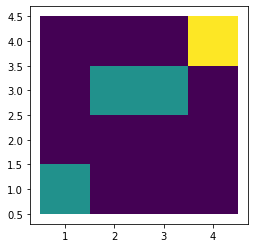

In [23]:
ploteo.plot(column = 'n')

## Poligonos Voronoi

In [24]:
#importamos la libreria que nos permite realizar la matematica de Vornoi
from scipy.spatial import Voronoi,voronoi_plot_2d

In [25]:
#necesitamos crear una lista de listas, donde cada sublista tenga las coordenadas en x y y de cada punto
#en este formato necesita los datos la libreria de scipy
[[g.x,g.y] for g in puntos.geometry]

[[4.5, 4.5], [4.3, 4.4], [0.5, 0.5], [2.0, 3.0], [3.0, 3.0]]

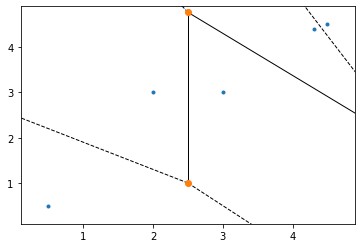

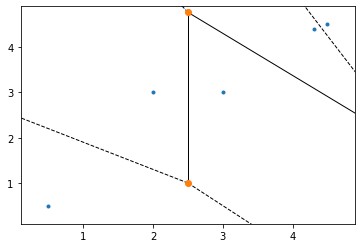

In [36]:
#creamos el objeto voronoi
vor = Voronoi([[g.x,g.y] for g in puntos.geometry])
voronoi_plot_2d(vor)

In [37]:
type(vor)

scipy.spatial.qhull.Voronoi

In [38]:
#esta funcion toma el objeto voronoi y un radio. Algunas lineas se proyectan hacia el infinito, 
#el radio las corta en ese radio

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [39]:
#aplicamos esa funcion y nos devuelve regiones y vertices
regions, vertices = voronoi_finite_polygons_2d(vor,radius=100)

#a partir de esta informacion podemos crear un geodataframe de voronois
voro_poligons = gpd.GeoDataFrame({'geometry':[Polygon(vertices[regions[i]]) for i in range(len(regions))]},crs = {'init':'epsg:3857'})
voro_poligons['id_voronoi'] = ['A','B','C','D','E']


In [40]:
voro_poligons.geometry.centroid

0      POINT (14.41311 7.99401)
1    POINT (-26.06458 57.90203)
2     POINT (-2.51287 -5.42037)
3    POINT (-42.33126 47.27666)
4    POINT (38.71973 -33.20725)
dtype: geometry

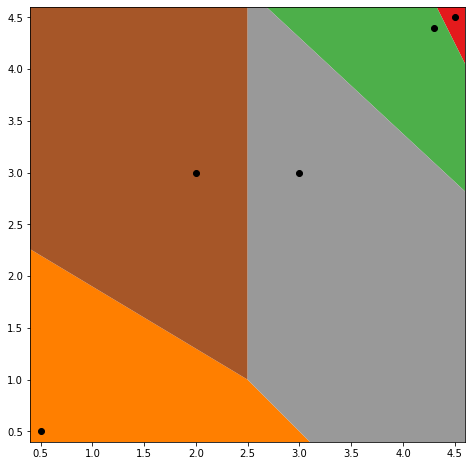

In [41]:
#ploteamos los datos
f,ax=plt.subplots(1,figsize=(8,8))
voro_poligons.plot(ax=ax,column='id_voronoi',cmap='Set1')    
puntos.plot(ax=ax,color='black')
ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1);


In [42]:
#noten que cada punto queda asignado a un solo voronoi
gpd.sjoin(puntos,voro_poligons)

,geometry,index_right,id_voronoi
0,POINT (4.50000 4.50000),0,A
1,POINT (4.30000 4.40000),1,B
2,POINT (0.50000 0.50000),2,C
3,POINT (2.00000 3.00000),3,D
4,POINT (3.00000 3.00000),4,E
